Lectura de archivo en excel con todas sus hojas

In [4]:
# Importar las librerías necesarias
import pandas as pd

# Especificar la ruta del archivo en "files"
file_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/subestacion _canaima _1000kva.xlsx'

# Cargar el archivo de Excel
excel_data = pd.ExcelFile(file_path)

# Ver las hojas del archivo de Excel
excel_data.sheet_names


['tension',
 'corriente',
 'energia',
 'Factor P',
 'Flickers (Pst)',
 'Flickers (Plt)',
 'Frecuencia',
 'potencia A',
 'Potencia Aparente',
 'potencia R I',
 'Distorsion armonica',
 'Armonicos  IL1',
 'Armonicos  IL2',
 'Armonicos  IL3',
 'Armonicos  VL1',
 'Armonicos  VL2',
 'Armonicos  VL3']

Consolidacion de datos es un solo data set por marca de tiempo

In [5]:
# Función para consolidar las hojas del Excel basadas en 'Fecha' y 'Tiempo'
def consolidate_sheets(excel_data, sheet_names):
    consolidated_df = None
    
    for sheet in sheet_names:
        sheet_df = excel_data.parse(sheet)
        
        # Combinar Fecha y Tiempo en una sola columna timestamp
        if 'Fecha' in sheet_df.columns and 'Tiempo' in sheet_df.columns:
            # Convertir 'Fecha' a string si es necesario
            if pd.api.types.is_datetime64_any_dtype(sheet_df['Fecha']):
                sheet_df['Fecha'] = sheet_df['Fecha'].dt.strftime('%Y-%m-%d')
            
            # Convertir 'Tiempo' a string si es de tipo datetime.time
            sheet_df['Tiempo'] = sheet_df['Tiempo'].apply(lambda x: x.strftime('%H:%M:%S') if isinstance(x, pd._libs.tslibs.timestamps.Timestamp) or isinstance(x, pd._libs.tslibs.nattype.NaTType) else x.strftime('%H:%M:%S'))
            
            # Crear la columna timestamp
            sheet_df['timestamp'] = pd.to_datetime(sheet_df['Fecha'] + ' ' + sheet_df['Tiempo'])
            sheet_df = sheet_df.drop(columns=['Fecha', 'Tiempo'])
        
        # Unir todas las hojas
        if consolidated_df is None:
            consolidated_df = sheet_df
        else:
            consolidated_df = pd.merge(consolidated_df, sheet_df, on='timestamp', how='outer')

    return consolidated_df

# Consolidar las hojas
sheet_names = excel_data.sheet_names
consolidated_data = consolidate_sheets(excel_data, sheet_names)

# Ver una muestra de los datos consolidados
print(consolidated_data.head())


   Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
0               264.21           264.42               264.73   
1               264.37           264.73               264.93   
2               264.57           264.78               265.02   
3               264.54           264.77               265.00   
4               264.50           264.85               265.07   

   Tensión MIN: L2 (V)  Tensión: L2 (V)  Tensión MAX: L2 (V)  \
0               268.12           268.32               268.46   
1               268.42           268.59               268.80   
2               268.52           268.65               268.85   
3               268.29           268.60               268.88   
4               268.41           268.65               268.85   

   Tensión MIN: L3 (V)  Tensión: L3 (V)  Tensión MAX: L3 (V)  \
0               266.51           266.73               266.92   
1               266.69           266.98               267.20   
2               266.87           267.0

Validacion de datos

In [6]:
# Validación de los datos consolidados

# 1. Verificar si hay valores faltantes
missing_data = consolidated_data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_data[missing_data > 0])

# 2. Verificar si hay registros duplicados basados en 'timestamp'
duplicates = consolidated_data.duplicated(subset='timestamp').sum()
print(f"\nNúmero de registros duplicados: {duplicates}")

# 3. Verificar los tipos de datos de las columnas
print("\nTipos de datos por columna:")
print(consolidated_data.dtypes)

# 4. Generar estadísticas descriptivas de las columnas numéricas
print("\nEstadísticas descriptivas:")
print(consolidated_data.describe())


Valores faltantes por columna:
Series([], dtype: int64)

Número de registros duplicados: 0

Tipos de datos por columna:
Tensión MIN: L1 (V)                  float64
Tensión: L1 (V)                      float64
Tensión MAX: L1 (V)                  float64
Tensión MIN: L2 (V)                  float64
Tensión: L2 (V)                      float64
                                      ...   
Armónicos VL3: Armónico 46 (%VL3)      int64
Armónicos VL3: Armónico 47 (%VL3)      int64
Armónicos VL3: Armónico 48 (%VL3)      int64
Armónicos VL3: Armónico 49 (%VL3)      int64
Armónicos VL3: Armónico 50 (%VL3)      int64
Length: 382, dtype: object

Estadísticas descriptivas:
       Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
count          7141.000000      7141.000000          7141.000000   
mean            264.445552       264.734348           265.000815   
min             257.010000       258.960000           259.320000   
25%             262.740000       263.040000           263.

Normalización de los datos y clustering con K-Means

determinar el número óptimo de clusters:Método del Codo, Mide la suma de las distancias al centroide (inercia) y grafica esta métrica a medida que se aumenta el número de clusters. se busca un "codo" en la gráfica, donde agregar más clusters no mejora significativamente la inercia.

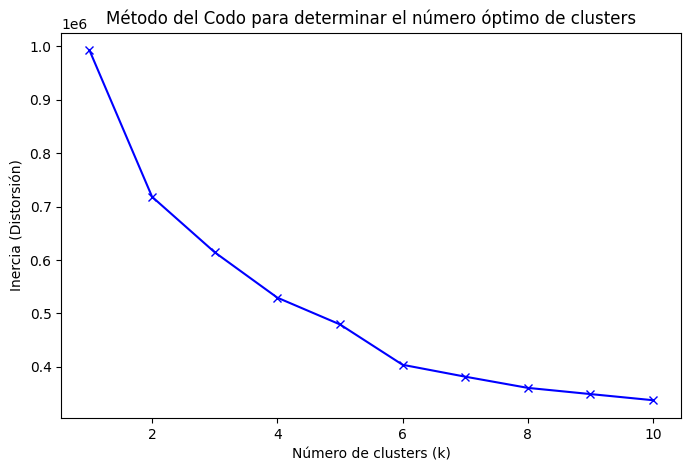

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Probar diferentes valores de k (número de clusters)
distortions = []
K = range(1, 11)  # Prueba desde 1 hasta 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)  # Guardar la inercia (distancia al centroide)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Distorsión)')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

Normalizacion y cluster con 4

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Seleccionar solo las columnas numéricas para normalizar
numerical_columns = consolidated_data.select_dtypes(include=['float64', 'int64']).columns

# Normalizar los datos usando StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(consolidated_data[numerical_columns])

# Aplicar K-Means con un número de clusters, 
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

# Agregar los resultados del clustering al dataframe consolidado
consolidated_data['Cluster'] = kmeans.labels_

# Mostrar una muestra de los datos con los clusters asignados
print(consolidated_data[['timestamp', 'Cluster']].head())


            timestamp  Cluster
0 2013-05-04 16:07:00        2
1 2013-05-04 16:08:00        2
2 2013-05-04 16:09:00        2
3 2013-05-04 16:10:00        2
4 2013-05-04 16:11:00        2


In [19]:
# Ver la distribución de los registros en los diferentes clusters
cluster_distribution = consolidated_data['Cluster'].value_counts()

# Mostrar la cantidad de datos asignados a cada cluster
print("Distribución de los registros en los clusters:")
print(cluster_distribution)


Distribución de los registros en los clusters:
Cluster
3    2330
1    2216
0    1507
2    1088
Name: count, dtype: int64
